# Fig, Axes, jm_functions

## TO-DO Core!
- Definir cuantos y cuales pkgs vas a crear:
    - El tema limitante es que se debe evitar la llamada recursina, es decir desde un mismo pkg llamar una función de dicho pkg o sea en algún módulo de dicho pkg llamar un módulo de dicho pkg?
    - Lista tentiva sería muuuchoos pkgs: jm_utils, jm_np, jm_pd, jm_plt, jm_sns
- Sepearar el alcance de to_series() - get_fdt() - grphs functions () usan get fdt pero hay que definir cuales parámetros le pasamos a la grpahs functions
- ax_plt-{charts} si hacemos pequeñas funciones que hagan todo a a uno las posibilidas. Acá hay dos puntos:
    1. Separar el ax_plt_pie() del fig_plt_pie() (o simplemente plt_pie) lo que va a traer el desafío de manejar escales con varios subplots , y no sé si conviene en un ajuste automático, sino que se maneje con figsize y scale como independientes. ¡?  - probaremos
    2. Dentro del ax_plt_pie separar los distintos tipos de kind y de labeling en subfunciones ¡?  - no sé si conviene meterse en esta ya lo tenemos solucionado con la funcionota no demorarse por ahora
    3. Resolver el tema de legend size antes..

In [1]:
## Standard Libs
from typing import Union, Optional, Any, Literal, Sequence, TypeAlias
import random

# Third-party Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

# Local Libs
from jm_datascience import jm_pandas as jm_pd

## Custom types for non-included typing annotations
IndexElement: TypeAlias = Union[str, int, float, pd.Timestamp]
# IndexElement: TypeAlias = Union[str, int, float, 'datetime.datetime', np.str_, np.int64, np.float64, np.datetime64, pd.Timestamp, ...]

In [2]:
# Data
dic = {'1603 SW': [21, 'No POE'], '1608 SW': [6, 'Headset compatible'], 
       '1616 SW': [3, 'Telefonista'], '9611 G': [8, 'Gerencial Gigabit']}
df = pd.DataFrame.from_dict(dic, orient='index', columns=['Stock', 'Obs'])
df

,Stock,Obs
1603 SW,21,No POE
1608 SW,6,Headset compatible
1616 SW,3,Telefonista
9611 G,8,Gerencial Gigabit


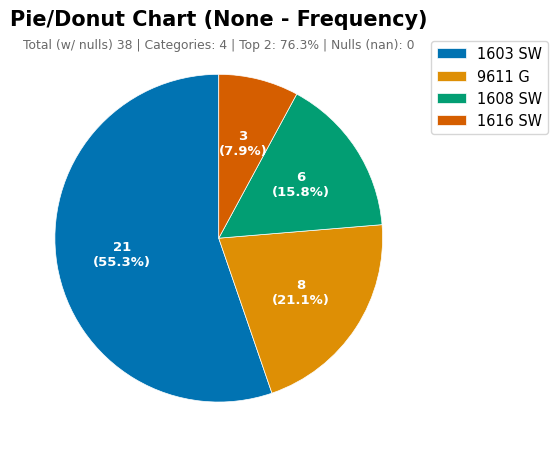

In [3]:
fig, ax = jm_pd.plt_pie(df['Stock'], label_place='int', scale=2)

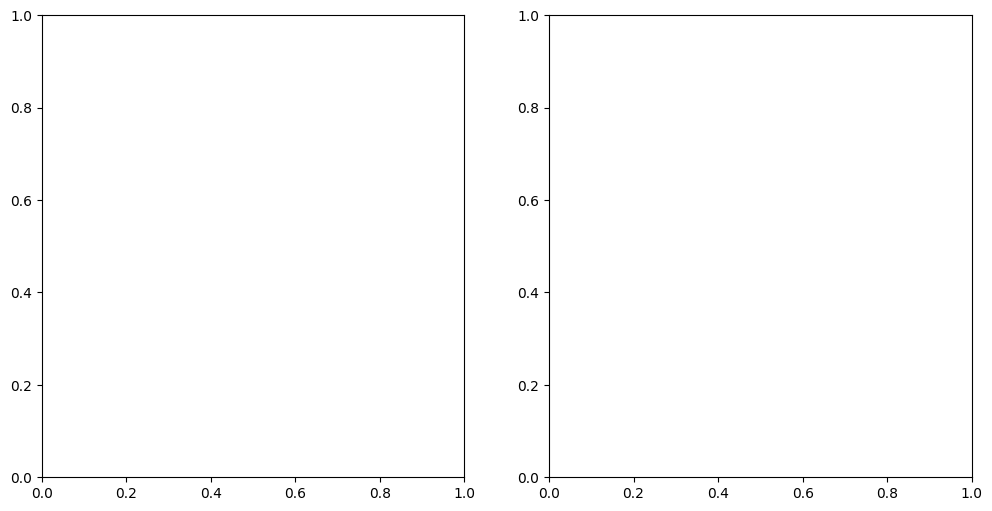

In [4]:
## Try to do new fig of figs?
# 1. Get the axes for new subplots figure
pltt1, pltt2 = 'colorblind', 'Set1'
p1_fig, p1_ax = jm_pd.plt_pie(df['Stock'], label_place='int', scale=2, palette=pltt1)
plt.close()     # To avoid displayn the p1_fig
p2_fig, p2_ax = jm_pd.plt_pie(df['Stock'], label_place='int', scale=2, palette=pltt2)
plt.close()

# 2. Define new fig
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Assing new axes to the ones created aerli
ax1 = p1_ax
ax2 = p2_ax


# p1_fig, p1_ax = jm_pd.plt_pie(df['Stock'], label_place='int', scale=2)


## plt_pie con ax INDEPENDIENTE
1. función plt_pie_on_ax(...params..). Params:
    -""" esta func. solo dibuja todo sobre el linezo ax que se le pasa de parámetro, modifica el mismísimo parámetro de entrada, o sea es 'inplace=True' """
    - ax (ax sonde se va a desplegar el plt_pie)
    - ... demás param de plt.pie()
2. función plt_pie():
    -""" esta dibuja la fig definitiva utilizando al función para el ax los parmas serán propios de una figure """
    - figsize()
    . ---

In [5]:
## Auxiliar Functions
def _fmt_value_for_pd(value, width=8, n_decimals=3, thousands_sep=',') -> str:
    """
    Format a value (numeric or string) into a right-aligned string of fixed width.

    Converts numeric values to formatted strings with thousands separators and
    specified decimal places. Strings are padded to the same width for consistent alignment.

    Parameters:
        value (int, float, str): The value to be formatted.
        width (int): Total width of the output string. Must be a positive integer.
        decimals (int): Number of decimal places for numeric values. Must be >= 0.
        miles (str or None): Thousands separator. Valid options: ',', '_', or None.

    Returns:
        str: The formatted string with right alignment.

    Raises:
        ValueError: If width <= 0, decimals < 0, or miles is invalid.

    Examples:
        >>> format_value(123456.789)
        '123,456.79'
        >>> format_value("text", width=10)
        '      text'
        >>> format_value(9876, miles=None)
        '    9876.00'
    """
    if not isinstance(width, int) or width <= 0:
        raise ValueError(f"Width must be a positive integer. Not '{width}'")
    
    if not isinstance(n_decimals, int) or n_decimals < 0:
        raise ValueError(f"Decimals must be a non-negative integer. Not '{n_decimals}")
    
    if thousands_sep not in [',', '_', None]:
        raise ValueError(f"Miles must be either ',', '_', or None. Not '{thousands_sep}")
    
    try:
        num = float(value)                                          # Convert to float if possible
        if num % 1 == 0:                                            # it its a total integer number
            decimals = 0
        if thousands_sep:
            return f"{num:>{width}{thousands_sep}.{n_decimals}f}"   # Fixed width, 'x' decimal places, right aligned
        else:
            return f"{num:>{width}.{n_decimals}f}"
        
    except (ValueError, TypeError):
        return str(value).rjust(width)                              # Also align strings, to maintain the grid


def _validate_numeric_series(
        pd_data: Union[pd.Series, pd.DataFrame],
        positive: Optional[bool] = True
) -> Union[None, Exception]:

    # Validate data parameter a pandas object
    if not isinstance(pd_data, (pd.Series, pd.DataFrame)):     # pd.Series or pd.Datafram
        raise TypeError(
            f"Input data must be a pandas Series or DataFrame. Got {type(pd_data)} instead."
        )
              
    if positive:
        if not all(                                             # Only positve numeric values
            isinstance(val, (int, float, np.integer, np.floating)) and val > 0 for val in pd_data.values
        ):
            raise ValueError(f"All values in the data must be positive numeric..")
        pass
    else:                                                       # Just only numeric values
        if not all(isinstance(val, (int, float, np.integer, np.floating)) for val in pd_data.values):
            raise ValueError(f"All values in the data must be numeric values.")
        pass


def to_series(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    index: Optional[Union[pd.Index, Sequence[IndexElement]]] = None,
    name: Optional[str] = None
) -> pd.Series:
    """
    Converts input data into a pandas Series with optional custom index and name.

    This function standardizes various data types into a pandas Series. It supports
    arrays, dictionaries, lists, sets, DataFrames, and existing Series. Optionally,
    a custom index or series name can be assigned.

    Parameters:
        data (Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame]):
            Input data to convert. Supported types:
            - pd.Series: returned as-is (can be overridden with new index/name).
            - np.ndarray: flattened and converted to a Series.
            - dict: keys become the index, values become the data.
            - list or set: converted to a Series with default integer index.
            - pd.DataFrame:
                - 1 column: converted directly to a Series.
                - 2 columns: first column becomes the index, second becomes the values.
        index (Union[pd.Index, Sequence], optional): Custom index to assign to the Series.
            If provided, overrides the original index. Default is None.
        name (str, optional): Name to assign to the Series. Default is None.

    Returns:
        pd.Series: A pandas Series constructed from the input data, with optional
            custom index and name.

    Raises:
        TypeError: If the input data type is not supported.
        ValueError: If the DataFrame has more than 2 columns.

    Examples:
        >>> import pandas as pd
        >>> to_series([1, 2, 3, 4])
        0    1
        1    2
        2    3
        3    4
        dtype: int64

        >>> to_series({'A': 10, 'B': 20, 'C': 30})
        A    10
        B    20
        C    30
        dtype: int64

        >>> df = pd.DataFrame({'Label': ['X', 'Y'], 'Value': [100, 200]})
        >>> to_series(df)
        Label
        X    100
        Y    200
        Name: Value, dtype: int64

        >>> to_series([10, 20, 30], index=['a', 'b', 'c'], name='Measurements')
        a    10
        b    20
        c    30
        Name: Measurements, dtype: int64
    """
    
    # Validate parameters - FUTURE
    
    if isinstance(data, pd.Series):                 # If series is already a Series no conversion needed
        series = data                                  
    elif isinstance(data, np.ndarray):              # If data is a NumPy array   
        series = pd.Series(data.flatten())
    elif isinstance(data, (dict, list)):
        series = pd.Series(data)
    elif isinstance(data, (set)):
        series = pd.Series(list(data))
    elif isinstance(data, pd.DataFrame):
        if data.shape[1] == 1:                      # Also len(data.columns == 1)
            series = data.iloc[:, 0]
        elif data.shape[1] == 2:                    # Index: first col, Data: 2nd Col
            series = data.set_index(data.columns[0])[data.columns[1]]
        else:
            raise ValueError("DataFrame must have 1 oer 2 columns. Categories and values for 2 columns cases.")
    else:
        raise TypeError(f"Unsupported data type: {type(data)}. "
                    "Supported types: pd.Series, np.ndarray, pd.DataFrame, dict, list, set, and pd.DataFrame")

    if name:
        series.name = name

    if index:
        series.index = index

    return series

                      
def get_fdt(
        data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
        value_counts: Optional[bool] = False,
        dropna: Optional[bool] = True,
        na_position: Optional[str] = 'last',
        include_pcts: Optional[bool] = True,
        include_flat_relatives: Optional[bool] = True,
        fmt_values: Optional[bool] = False,
        order: Optional[str] = 'desc',
        na_aside_calc: Optional[bool] = True,
        index_name: Optional[str] = None
) -> pd.DataFrame:
    """
    Generates a Frequency Distribution Table (FDT) with absolute, relative, and cumulative frequencies.

    This function converts various input data types into a structured DataFrame containing:
    - Absolute frequencies
    - Cumulative frequencies
    - Relative frequencies (proportions and percentages)
    - Cumulative relative frequencies (percentages)

    Parameters:
        data (Union[pd.Series, np.ndarray, dict, list, pd.DataFrame]): Input data.
            If DataFrame, it will be converted to a Series using `to_series`.
        value_counts (bool, optional): Whether to count occurrences if input is raw data.
            Assumes data is not pre-counted. Default is False.
        dropna (bool, optional): Whether to exclude NaN values when counting frequencies.
            Default is True.
        na_position (str, optional): Position of NaN values in the output:
            - 'first': Place NaN at the top.
            - 'last': Place NaN at the bottom (default).
            - 'value': Keep NaN in its natural order.
            Default is 'last'.
        include_pcts (bool, optional): Whether to include percentage columns.
            If False, only absolute and cumulative frequencies are returned.
            Default is True.
        include_flat_relatives (bool, optional): Whether to return relative and cumulative relative values.
            If False, only frequency and percentage columns are included.
            Default is True.
        fmt_values (bool, optional): Whether to format numeric values using `_fmt_value_for_pd`.
            Useful for improving readability in reports. Default is False.
        order (str, optional): Sort order for the output:
            - 'asc': Sort values ascending.
            - 'desc': Sort values descending (default).
            - 'ix_asc': Sort by index ascending.
            - 'ix_desc': Sort by index descending.
            - None: No sorting.
            Default is 'desc'.
        na_aside_calc (bool, optional): Whether to separate NaN values from calculations but keep them in the output.
            If True, NaNs are added at the end and not included in cumulative or relative calculations.
            Default is True.
        index_name (str, optional): Set an specific index name for the fdt.

    Returns:
        pd.DataFrame: A DataFrame containing the frequency distribution table with the following columns
        (depending on parameters):
            - Frequency
            - Cumulative Frequency
            - Relative Frequency
            - Cumulative Relative Freq.
            - Relative Freq. [%]
            - Cumulative Freq. [%]

    Raises:
        ValueError: If `sort` or `na_position` receive invalid values.

    Notes:
        - This function uses `to_series` to convert input data into a pandas Series.
        - If `na_aside=True` and NaNs are present, they are placed separately and not included in relative calculations.
        - Useful for exploratory data analysis and generating clean statistical summaries.

    Example:
        >>> import pandas as pd
        >>> data = pd.Series(['A', 'B', 'A', 'C', 'B', 'B', None])
        >>> fdt = get_fdt(data, sort='desc', fmt_values=True)
        >>> print(fdt)
              Frequency  Cumulative Frequency  Relative Freq. [%]  Cumulative Freq. [%]
        B           3                   3                42.86                  42.86
        A           2                   5                28.57                  71.43
        C           1                   6                14.29                  85.71
        Nulls       1                   7                14.29                 100.00
    """
    columns = [
        'Frequency',
        'Cumulative Frequency',
        'Relative Frequency',
        'Cumulative Relative Freq.',
        'Relative Freq. [%]',
        'Cumulative Freq. [%]'
    ]
    # def _calculate_fdt_relatives(series):     # Revisar, no me gusta el flujo actual
    
    sr = to_series(data)
    
    if dropna:
        sr = sr.dropna()                        # Drop all nulls values of the Series
        sr = sr.drop(np.nan, errors='ignore')   # For series with NaNs as a category with their count (errors='ignore': does not fail if it does not exist)

    if value_counts:
        sr = sr.value_counts(dropna=dropna, sort=False)

    # Validate that all the values are positive numbers
    _validate_numeric_series(sr)

    # Order de original Series to obtain the fdt in the same order as the original data
    match order:
        case 'asc':
            sr = sr.sort_values()
        case 'desc':
            sr = sr.sort_values(ascending=False)
        case 'ix_asc':
            sr = sr.sort_index()
        case 'ix_desc':
            sr = sr.sort_index(ascending=False)
        case None:
            pass
        case _:
            raise ValueError(f"Valid values for order: 'asc', 'desc', 'ix_asc', 'ix_desc', or None. Got '{order}'")
        
    # Handle NaNs values. Two cases: 1. na_aside: don't use for calcs and at the end; 2. use for calcs and locate according na_position
    #   - Determine the number of nans
    if pd.isna(sr.index).any():
        n_nans = sr[np.nan]
    else:
        n_nans = 0

    #   - Locale NaNs row in the Series 'sr'
    if na_aside_calc:
        sr = sr.drop(np.nan, errors='ignore')                   # Drop NaNs from the Series for calculations
        # Column that will then be concatenated to the end of the DF - Only 'Frequency' column, no calculated columns
        nan_row_df = pd.DataFrame(data = [n_nans], columns=[columns[0]], index=[np.nan])
    else:
        # As we use NaNs for calculations decide where locate these values
        sr_without_nan = sr.drop(np.nan, errors='ignore')       # Aux. sr wo/nans allow us to locate the NaNs
        match na_position:             
            case 'first':
                sr = pd.concat([pd.Series({np.nan: n_nans}), sr_without_nan])
            case 'last':
                sr = pd.concat([sr_without_nan, pd.Series({np.nan: n_nans})])
            case 'value' | None:
                pass                # Locates the Nulls row based on the value or index ordering
            case _:
                raise ValueError(f"Valid values for na_position: 'first', 'last', 'value' or None. Got '{na_position}'")

    # Central rutine: create the fdt, including relative and cumulative columns.
    fdt = pd.DataFrame(sr)
    fdt.columns = [columns[0]]
    fdt[columns[1]] = fdt['Frequency'].cumsum()
    fdt[columns[2]] = fdt['Frequency'] / fdt['Frequency'].sum()
    fdt[columns[3]] = fdt['Relative Frequency'].cumsum()
    fdt[columns[4]] = fdt['Relative Frequency'] * 100
    fdt[columns[5]] = fdt['Cumulative Relative Freq.'] * 100

    if na_aside_calc and not dropna:            # We add nan_columns at the end
        fdt = pd.concat([fdt, nan_row_df])

    # Logic to include: only frequencies, or only flat relatives, or percentage (pcts)
    if not include_pcts and not include_flat_relatives:
        fdt = fdt[[columns[0]]]                             # Only 'Frecquency' (col[0]) - doble[[]] to get a DF
    elif not include_pcts and include_flat_relatives:
        fdt = fdt[columns[0:4]]                             # 'Frequency' + plain_relative cols (col[0,1,2,3])
    elif include_pcts and not include_pcts:
        fdt = fdt[[columns[0], columns[4], columns[5]]]     # 'Frequency' + pcts cols (last two cols)

    if fmt_values:
        fdt = fdt.map(_fmt_value_for_pd)

    # Set the index name
    fdt.index.name = index_name if index_name else sr.index.name
        
    return fdt

def get_colorblind_palette_list():
    """
    Retorna una lista de colores (hexadecimales) amigables para personas
    con daltonismo, equivalentes a sns.color_palette('colorblind').
    """
    return [
        '#0173B2', '#DE8F05', '#029E73', '#D55E00', '#CC78BC',
        '#CA9161', '#FBAFE4', '#949494', '#ECE133', '#56B4E9',
        '#5D8C3B', '#A93967', '#888888', '#FFC107', '#7C9680',
        '#E377C2', '#BCBD22', '#AEC7E8', '#FFBB78', '#98DF8A',
        '#FF9896', '#C5B0D5', '#C49C94', '#F7B6D2', '#DBDB8D',
        '#9EDAE5', '#D68E3A', '#A65898', '#B2707D', '#8E6C87'
    ]


def get_colors_list(palette: str, n_items: Optional[int] = 10) -> list[str]:
    """
    | Return a valid matplotlib palette list    | 'colorblind' is a kind of sns.colorblind 
    - Qualitatives (Cat) = ['tab10', 'tab20', 'Set1', 'Set2', 'Set3', 'Pastel1', 'Pastel2', 'Dark2', 'Paired', 'Accent', 'colorblind']
    - Sequential (Order) = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
    - Diverging (MidPoint) = ['coolwarm', 'bwr', 'seismic', 'PiYG', 'PRGn', 'BrBG', 'RdGy', 'RdBu', 'Spectral', 'RdYlGn', 'PuOr', 'RdYlBu']
    - Cyclic (Repeat)= ['twilight', 'twilight_shifted', 'hsv', 'turbo', 'cubehelix', 'gist_rainbow', 'jet', 'nipy_spectral', 'rainbow_r']
    - Mix = ['rainbow', 'flag', 'prism', 'ocean', 'terrain', 'gnuplot', 'CMRmap', 'hot', 'afmhot', 'gist_heat', 'copper', 'bone', 'pink']
    """
    if palette == 'colorblind':
        color_list = get_colorblind_palette_list()
    else:
        cmap = plt.get_cmap(palette, n_items)             # Use palette colormap
        color_list = [cmap(i) for i in range(n_items)]    # Get colors from the colormap

    return color_list

In [6]:
# data
df
fdt = get_fdt(df['Stock'], fmt_values=True) # ERROR ..ojo!
fdt

,Frequency,Cumulative Frequency,Relative Frequency,Cumulative Relative Freq.,Relative Freq. [%],Cumulative Freq. [%]
1603 SW,21.000,21.000,0.553,0.553,55.263,55.263
9611 G,8.000,29.000,0.211,0.763,21.053,76.316
1608 SW,6.000,35.000,0.158,0.921,15.789,92.105
1616 SW,3.000,38.000,0.079,1.000,7.895,100.000


In [8]:
def ax_plt_pie(
    ax: plt.Axes,
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',
    scale: Optional[int] = 1,
    figsize: Optional[tuple[float, float]] = None,
    subplots: Optional[int] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    palette: Optional[list] = None,
    startangle: Optional[float] = 90,
    label_place: Optional[str] = 'ext',
    label_rotate: Optional[float] = 0,
    pct_decimals: Optional[int] = 1,
    legend_loc: Optional[str] = 'best',
    legend_title: Optional[str] = None,
    show_stats_subtitle = True
) -> plt.Axes:
    """
    """
    # Get the data to graph: use controls and processing that get_fdt() does to obtain the series to graph (first column: 'Frequency')
    fdt = get_fdt(data, value_counts=value_counts, order=order,
                  dropna=False, na_position='value', na_aside_calc=False, include_flat_relatives=False, include_pcts=False)
        # - dropna=False            -> So that it doesn't remove NaNs, and then handle them
        # - na_aside_calc=False     -> So that it allows me to sort the nan value with na_position='value'
        # - na_position='value'     -> So that it allows me to sort the nan value within the list of values either desc or asc (according to order)
        # - We do not include relative flat rates or percentages. We calculate the percentages before presenting them.

    cat_name = fdt.index.name                       # Category name <- from fdt.index.name (could be 'Index' Warn!)

    sr = fdt.iloc[:, 0]                             # Get the Series with the frequencies (count)
    # As sr.index build the legends: If I want to change the legends, I'll have to see how I modify this sr.index (must be done previously aside)
         
    # Handling of nans since they are presented in the subtitle, whether or not they appear in the graph
    total_label = "Total (w/ nulls)"                # Default total_label to be presented in subtitle
    
    if pd.isna(sr.index).any():                     # There is np.nan [NaN] index, nans values
        n_nans = sr[np.nan]
        if dropna:                                  # No NaNs in the graph
            sr = sr.drop(np.nan, errors='ignore')   # Drop NaN row from the DataFrame
            total_label = "Total (wo/ nulls)"       # The total will be calculated wo/NaNs (likewise, n_nans will appear in the subtitle.)
    else:                                           # No np.nan row
        n_nans = 0

    # Validate kind parameter
    if kind.lower() not in ['pie', 'donut']:
        raise ValueError(f"Invalid 'kind' parameter: '{kind}'. Must be 'pie' or 'donut'.")
    
    # Validate maximum categories
    if len(sr) > 12:
        raise ValueError(f"Data contains {len(sr)} categories. "
                        "Maximum allowed is 12 categories.")
    
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 7.5
        w_base, h_base = 1, 0.56
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize
    
    # Calculate font sizes based on figure width
    label_size = width * 1.25
    title_size = width * 1.57

    # Base fig definitions
    # fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # Configure wedge properties for donut or pie chart
    wedgeprops = {}
    if kind.lower() == 'donut':
        wedgeprops = {'width': 0.54, 'edgecolor': 'white', 'linewidth': 1}
    else:
        wedgeprops = {'edgecolor': 'white', 'linewidth': 0.5}

    # Define colors
    color_palette = get_colors_list(palette, len(sr))

    if label_place == 'ext':

        wedges, texts = ax.pie(sr, wedgeprops=wedgeprops, colors=color_palette, startangle=startangle)

        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

        # Build the labels. Annotations and legend in same label (External)
        labels = [
            f"{sr.loc[sr == value].index[0]}\n{value}\n({round(value / sr.sum() * 100, pct_decimals)} %)"
            for value in sr.values
        ]
        
        # Draw the annotations (labels)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, fontsize=label_size, **kw)
            
    elif label_place == 'int' or label_place == 'aside':
        label_size = label_size * 0.8
        legend_size = label_size * 1.1
        
        # Set autopct and legends, different for 'int' and 'aside' label_place
        if label_place == 'int':
            # autopct for internal annotations. A funtion to show both: absolute an pcts.
            format_string = f'%.{pct_decimals}f%%'

            def _make_autopct(values, fmt_str):     # A python Closuer
                value_iterator = iter(values)
                
                def my_autopct(pct):
                    absolute_value = next(value_iterator)
                    percentage_string = fmt_str % pct
                    return f"{absolute_value}\n({percentage_string})"  
                
                return my_autopct
            
            autopct_function = _make_autopct(sr.values, format_string)

            legends = sr.index

        else:                           # elif aside:  Valid autopct and legends in case of 'aside' label_place
            autopct_function = None     # No data inside de pie or donut
            # Custom legends w/labels values and pct aside of the pie or donut
            total = sr.values.sum()         
            legends = [f"{sr.index[i]} \n| {value} | {round(value / total * 100, pct_decimals)} %"
                    for i, value in enumerate(sr.values)] 

        ax.pie(x=sr,
            colors=color_palette,
            startangle=startangle,
            autopct=autopct_function,
            wedgeprops=wedgeprops,
            textprops={'size': label_size,
                        'color': 'w',
                        'rotation': label_rotate,
                        'weight': 'bold'})
        
        ax.legend(legends,
                loc=legend_loc,
                # title=legend_title,
                bbox_to_anchor=(1, 0, 0.2, 1),
                prop={'size': legend_size})
        
        at = AnchoredText(legend_title,
                  loc="upper left",  # Adjust location as needed
                  frameon=False,
                  prop=dict(size=legend_size, weight='bold')) # Using a dictionary for font properties
        ax.add_artist(at)

    else:
        raise ValueError(f"Invalid labe_place parameter. Must be 'ext', 'int' or 'aside', not '{label_place}'.")
            
    # Build title and set title
    if not title:
        title = f"Pie/Donut Chart ({cat_name} - {sr.name})"
    ax.set_title(title, fontsize=title_size, fontweight='bold')

    if show_stats_subtitle:                     # Enhanced subtitle with statistics
        total_items = sr.sum()                  # Total items in the series
        n_categories = len(sr)                  # len(categories)
        top_2_pct = (sr.head(2).sum() / total_items * 100) if n_categories >= 3 else (sr.sum() / total_items * 100)

        subtitle = f"{total_label} {total_items:,} | Categories: {n_categories} | Top 2: {top_2_pct:.1f}% | Nulls (nan): {n_nans}"
        ax.text(0, 1.18, subtitle, ha='center', va='center', fontsize=title_size * 0.6, color='dimgray')

    return ax

In [9]:
def plt_pie(
    data: Union[pd.Series, np.ndarray, dict, list, set, pd.DataFrame],
    value_counts: Optional[bool] = False,
    dropna: Optional[bool] = True,
    order: Optional[str] = 'desc',
    scale: Optional[int] = 1,
    figsize: Optional[tuple[float, float]] = None,
    subplots: Optional[int] = None,
    title: Optional[str] = None,
    kind: Optional[str] = 'pie',
    palette: Optional[list] = None,
    startangle: Optional[float] = 90,
    label_place: Optional[str] = 'ext',
    label_rotate: Optional[float] = 0,
    pct_decimals: Optional[int] = 1,
    legend_loc: Optional[str] = 'best',
    legend_title: Optional[str] = None,
    show_stats_subtitle = True
) -> plt.Axes:
    """
    """
    # Build graphs size, and fonts size from scale, and validate scale from 1 to 9.
    if scale < 1 or scale > 9:
        raise ValueError(f"[ERROR] Invalid 'scale' value. Must between '1' and '9', not '{scale}'.")
    else:
        scale = round(scale)

    # Calculate figure dimensions
    if figsize is None:
        multiplier = scale + 7.5
        w_base, h_base = 1, 0.56
        width, height = w_base * multiplier, h_base * multiplier
        figsize = (width, height)
    else:
        width, height = figsize

    # Base fig
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    ax_plt_pie(ax, data, value_counts, dropna, order, scale, figsize, subplots, title, kind, palette, startangle,
               label_place, label_rotate, pct_decimals, legend_loc, legend_title, show_stats_subtitle)

    return fig, ax

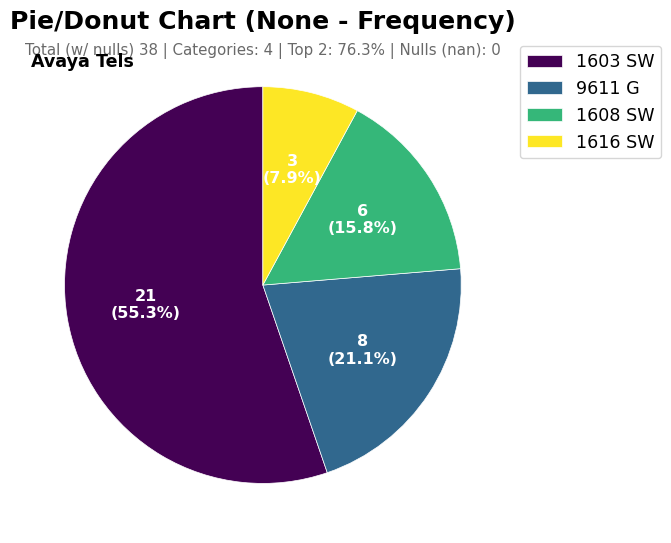

In [11]:
fig = plt_pie(data=df['Stock'], label_place='int', scale=4, legend_title='Avaya Tels')

In [ ]:
## crate 1st fig
fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))
ax_plt_pie(ax1, df['Stock'], scale=4, label_place='int')

In [ ]:
def plt_pie_on_ax(ax, sr, decimals=1):
    """
    Dibuja una función seno en un objeto Axes de Matplotlib proporcionado.
    
    Args:
        ax (matplotlib.axes.Axes): El eje donde se dibujará el gráfico.
    """
    pcts_fmt = f'%.{decimals}f%%'
    ax.pie(x=sr.values, autopct=pcts_fmt)
    ax.legend(sr.index)

In [ ]:
# data
df

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt_pie_on_ax(ax1, df['Stock'])
plt_pie_on_ax(ax2, df['Stock'], decimals=3)
fig.suptitle('Esta si es de la fig')

In [ ]:
def plt_sin(ax=None):
    x = np.linspace(0, 10, 100)
    y = np.sin(x)
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 1))
    ax.plot(x, y)
    ax.set_title("Gráfica de Seno")
    return ax

def plt_pie0(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))
    ax.pie(x=[60, 30, 10], labels=['A', 'B', 'C'],
           startangle=90, autopct='%1.1f%%')
    ax.set_title("Gráfica de Torta")
    return ax

# Nueva figura combinada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt_sin(ax1)
plt_pie0(ax2)
plt.tight_layout()
plt.show()


In [ ]:
def plot_sin_on_ax(ax):
    """
    Dibuja una función seno en un objeto Axes de Matplotlib proporcionado.
    
    Args:
        ax (matplotlib.axes.Axes): El eje donde se dibujará el gráfico.
    """
    x = np.linspace(0, 10, 100)
    y = np.sin(x)
    ax.plot(x, y)
    ax.set_title("Gráfica de Seno")
    ax.set_xlabel("x")
    ax.set_ylabel("sin(x)")
    ax.grid(True, linestyle='--', alpha=0.6)

def plot_pie_on_ax(ax):
    """
    Dibuja un gráfico de torta en un objeto Axes de Matplotlib proporcionado.

    Args:
        ax (matplotlib.axes.Axes): El eje donde se dibujará el gráfico.
    """
    data = [60, 30, 10]
    labels = ['A', 'B', 'C']
    ax.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.set_title("Gráfico de Torta")
    # Asegura que el gráfico de torta sea un círculo.
    ax.axis('equal')  

# --- Script Principal para Combinar los Gráficos ---

# 1. Crear una figura y una grilla de subplots. 
#    1 fila, 2 columnas. figsize ajusta el tamaño total de la figura.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# 2. Añadir un título general a toda la figura.
fig.suptitle('Figura Combinada con Subplots', fontsize=16)

# 3. Llamar a cada función para que dibuje en su respectivo subplot.
plot_sin_on_ax(ax1)
plot_pie_on_ax(ax2)

# 4. Ajustar el espaciado entre subplots para que no se superpongan los títulos.
plt.tight_layout(rect=[0, 0, 1, 0.95]) # El rect ajusta el espacio para el suptitle

# 5. Mostrar la figura final.
plt.show()

In [ ]:
def plt_sin():
    x = np.linspace(0, 10, 100)
    y = np.sin(x)

    # Build fig an ax
    fig, ax = plt.subplots(figsize=(3, 1))
    ax.plot(x, y)
    ax.set_title("Gráfica de Seno")

    return fig, ax

# Guardar la figura (opcional)
# plt.savefig('mi_grafica.png')

# # Cierra la figura para que no se muestre en la celda
# plt.close()

In [ ]:
def plt_pie0():
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.bar = plt.pie(x=[60, 30, 10], labels=['A', 'B', 'C'],
                    startangle=90,
                    autopct='%1.1f%%')
    return fig, ax

In [ ]:
f1, ax1 = plt_sin()
plt.close()
f2, ax2 = plt_pie0()
plt.close()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# ax1.set_title('casa')